### NNX

NNX is an experimental library built on top of Flax (and JAX) that introduces a new way of organizing models and parameters.

Flax + object-oriented control + simpler parameter handling.

Selective adaptation: only update certain layers or parameters

Model interventions: probing layers, freezing/unfreezing dynamically

EKF updates: replacing gradient descent for specific parameters


→ Flax’s standard TrainState setup is not flexible enough for this.

→ NNX gives direct access and fine-grained control of parameters and submodules.

| Concept                    | Meaning                                                                                   |
| -------------------------- | ----------------------------------------------------------------------------------------- |
| `nnx.Module`               | Like `flax.linen.Module`, but fully **object-based**. You can mutate attributes directly. |
| `nnx.Param`                | Marks something as a learnable parameter.                                                 |
| `nnx.Variable`             | General container for mutable state (like batch norm stats).                              |
| `nnx.state(model)`         | Captures all current parameters and states.                                               |
| `nnx.apply(model, state)`  | Applies the model’s forward pass with a given state.                                      |
| `nnx.update(state, grads)` | Updates parameters (you can write your own rules here).                                   |

In [1]:
import jax
import jax.numpy as jnp
import flax.nnx as nnx  

class TinyMLP(nnx.Module):
    def __init__(self, rngs: nnx.Rngs):
        # Layers — note: we don’t pass key= anymore
        self.dense1 = nnx.Linear(784, 128, rngs=rngs)
        self.dense2 = nnx.Linear(128, 10, rngs=rngs)

    def __call__(self, x):
        x = jax.nn.relu(self.dense1(x))
        return self.dense2(x)

# Initialize model
rngs = nnx.Rngs(0)   # handles all RNGs internally
model = TinyMLP(rngs)

# Create input
x = jax.random.normal(jax.random.PRNGKey(1), (1, 784))

# Forward pass
y_pred = model(x)
print("Output shape:", y_pred.shape)

INFO:2025-10-23 06:26:49,463:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-10-23 06:26:49,465:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Output shape: (1, 10)


In [2]:
print(model.dense1.kernel.value.shape)
# model.dense1.kernel.value *= 0.5  # Direct intervention!

(784, 128)


2025-10-23 06:26:51.906902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761200811.928987    1394 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761200811.935727    1394 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


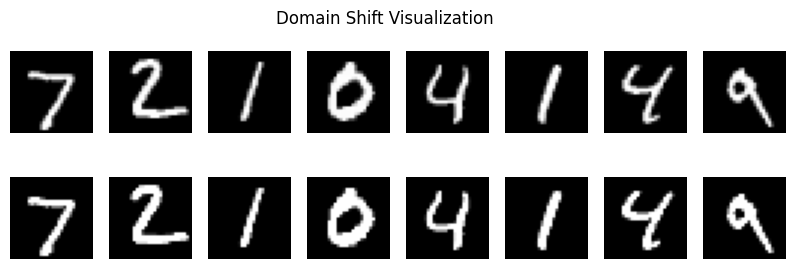


Training baseline RNN...
Epoch 1/30: train_loss=2.3202 test_acc=0.2433
Epoch 2/30: train_loss=2.1945 test_acc=0.2970
Epoch 4/30: train_loss=2.0029 test_acc=0.4074
Epoch 6/30: train_loss=1.7783 test_acc=0.4637
Epoch 8/30: train_loss=1.6065 test_acc=0.5248
Epoch 10/30: train_loss=1.4703 test_acc=0.5340
Epoch 12/30: train_loss=1.3577 test_acc=0.5868
Epoch 14/30: train_loss=1.2478 test_acc=0.6126
Epoch 16/30: train_loss=1.1743 test_acc=0.6256
Epoch 18/30: train_loss=1.0900 test_acc=0.6350
Epoch 20/30: train_loss=1.0691 test_acc=0.6513
Epoch 22/30: train_loss=0.9729 test_acc=0.6757
Epoch 24/30: train_loss=0.9354 test_acc=0.6816
Epoch 26/30: train_loss=0.9127 test_acc=0.6995
Epoch 28/30: train_loss=0.8726 test_acc=0.6995
Epoch 30/30: train_loss=0.8227 test_acc=0.7123
Baseline accuracy (orig): 0.7123
Baseline accuracy (shifted): 0.7199

Selective adaptation (fc layer only)...
Adapt Epoch 1/3: loss=0.8004 acc=0.7200
Adapt Epoch 2/3: loss=0.8002 acc=0.7203
Adapt Epoch 3/3: loss=0.8001 acc=0.72

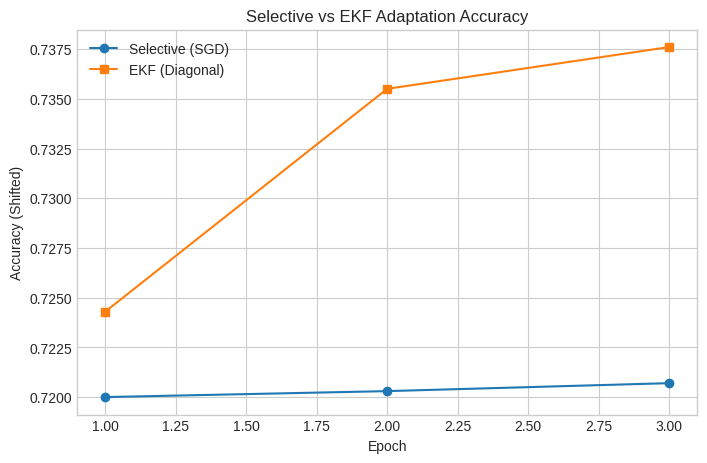

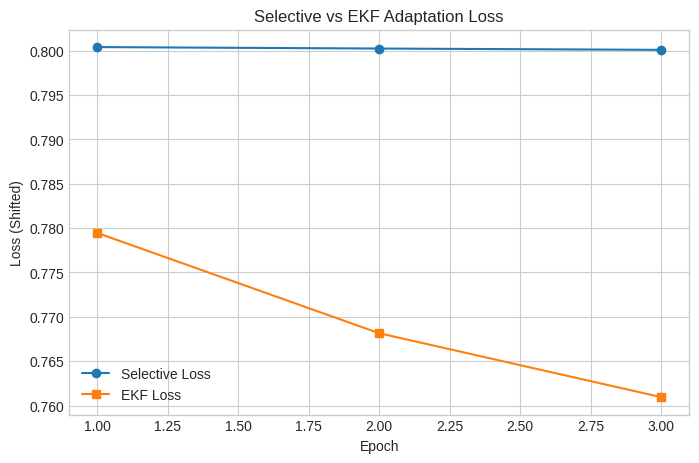


Δ Params Selective → EKF: 0.247541


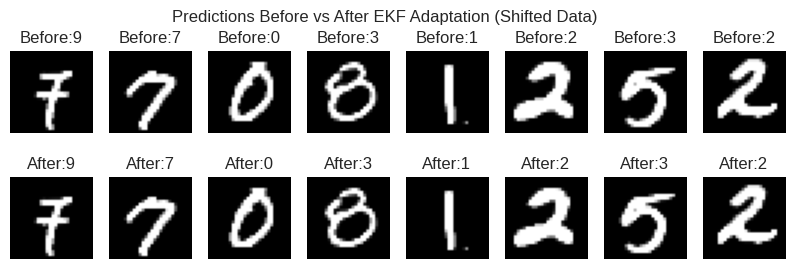

In [3]:
# =====================================
# 1. Setup and Data Preparation
# =====================================
import jax, jax.numpy as jnp
import optax, numpy as np, matplotlib.pyplot as plt, time
from flax import nnx
from tensorflow.keras.datasets import mnist
import copy

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(-1, 28, 28)
X_test  = X_test.reshape(-1, 28, 28)

# contrast and brightness shift
X_test_shifted = np.clip(((X_test - 0.5) * 1.8 + 0.5) + 0.4, 0, 1)
y_test_shifted = y_test

fig, axes = plt.subplots(2, 8, figsize=(10, 3))
for i in range(8):
    axes[0, i].imshow(X_test[i], cmap="gray");       axes[0, i].axis("off")
    axes[1, i].imshow(X_test_shifted[i], cmap="gray");axes[1, i].axis("off")
axes[0, 0].set_ylabel("Original", rotation=0, labelpad=40)
axes[1, 0].set_ylabel("Shifted", rotation=0, labelpad=40)
plt.suptitle("Domain Shift Visualization")
plt.show()

# =====================================
# 2. Define Simple RNN Model (NNX)
# =====================================
class SimpleRNN(nnx.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, *, rngs: nnx.Rngs):
        # input-to-hidden and hidden-to-hidden transformations
        self.hidden_size = hidden_dim
        self.Wxh = nnx.Linear(input_dim, hidden_dim, rngs=rngs)
        self.Whh = nnx.Linear(hidden_dim, hidden_dim, rngs=rngs)
        self.fc  = nnx.Linear(hidden_dim, num_classes, rngs=rngs)

    def __call__(self, x, h):
        # x: (batch, seq, feat)
        for t in range(x.shape[1]):
            h = jnp.tanh(self.Wxh(x[:, t, :]) + self.Whh(h))
        return self.fc(h)

# =====================================
# 3. Loss, Accuracy, and Utility
# =====================================
def cross_entropy(logits, labels):
    y = jax.nn.one_hot(labels, 10)
    return -jnp.mean(jnp.sum(y * jax.nn.log_softmax(logits), axis=-1))

def accuracy(logits, labels):
    return jnp.mean(jnp.argmax(logits, -1) == labels)

def eval_batch(model, x, y):
    h0 = jnp.zeros((x.shape[0], model.hidden_size))
    logits = model(x, h0)
    return cross_entropy(logits, y), accuracy(logits, y)

# =====================================
# 4. Baseline Training (improved)
# =====================================
rngs = nnx.Rngs(0)
model = SimpleRNN(28, 128, 10, rngs=rngs)
optimizer = nnx.Optimizer(model, optax.adam(2e-3))

epochs = 30
batch_size = 1024
train_losses, test_accs = [], []

print("\nTraining baseline RNN...")
for ep in range(epochs):
    # random mini-batch sampling
    idx = np.random.choice(len(X_train), batch_size, replace=False)
    Xb, yb = X_train[idx], y_train[idx]

    def loss_fn(model):
        h0 = jnp.zeros((Xb.shape[0], model.hidden_size))
        logits = model(Xb, h0)
        loss = cross_entropy(logits, yb)
        return loss, logits

    (loss_value, _), grads = nnx.value_and_grad(loss_fn, has_aux=True)(model)
    optimizer.update(grads)

    # evaluate every 2 epochs
    if (ep + 1) % 2 == 0 or ep == 0:
        l, a = eval_batch(model, X_test, y_test)
        train_losses.append(float(loss_value))
        test_accs.append(float(a))
        print(f"Epoch {ep+1}/{epochs}: train_loss={float(loss_value):.4f} test_acc={float(a):.4f}")

baseline_model = copy.deepcopy(model)
l_shift, a_shift = eval_batch(model, X_test_shifted, y_test_shifted)
print(f"Baseline accuracy (orig): {test_accs[-1]:.4f}")
print(f"Baseline accuracy (shifted): {a_shift:.4f}")

# =====================================
# 5. Selective Adaptation (SGD on head only)
# =====================================
selective_model = copy.deepcopy(baseline_model)
sel_opt = nnx.Optimizer(selective_model.fc, optax.adam(1e-3))
sel_losses, sel_accs = [], []
num_adapt_epochs = 3

print("\nSelective adaptation (fc layer only)...")

for ep in range(num_adapt_epochs):
    Xb, yb = X_test_shifted, y_test_shifted

    def loss_fn(fc):
        h0 = jnp.zeros((Xb.shape[0], selective_model.hidden_size))
        h_final = jax.lax.stop_gradient(
            jnp.tanh(
                selective_model.Wxh(Xb[:, -1, :]) +
                selective_model.Whh(h0)
            )
        )
        logits = fc(h_final)
        loss = cross_entropy(logits, yb)
        return loss, logits


    (loss_value, _), grads = nnx.value_and_grad(loss_fn, has_aux=True)(selective_model.fc)
    sel_opt.update(grads)

    l, a = eval_batch(selective_model, X_test_shifted, y_test_shifted)
    sel_losses.append(float(l))
    sel_accs.append(float(a))
    print(f"Adapt Epoch {ep+1}/{num_adapt_epochs}: loss={float(l):.4f} acc={float(a):.4f}")


# =====================================
# 6. EKF Adaptation (Diagonal Covariance)
# =====================================
print("\nEKF-based adaptation (fc layer)...")
ekf_model = copy.deepcopy(baseline_model)
fc = ekf_model.fc
W, b = fc.kernel.value, fc.bias.value
P = jnp.ones_like(W) * 0.1
Q = jnp.ones_like(W) * 0.01
R = 0.05
ekf_accs, ekf_losses = [], []

for ep in range(num_adapt_epochs):
    # 🔹 Compute real hidden states (not zeros)
    h = jnp.zeros((X_test_shifted.shape[0], ekf_model.hidden_size))
    for t in range(X_test_shifted.shape[1]):
        h = jnp.tanh(ekf_model.Wxh(X_test_shifted[:, t, :]) + ekf_model.Whh(h))
    logits = ekf_model.fc(h)

    # 🔹 Compute prediction error
    y_pred = jax.nn.softmax(logits)
    y_true = jax.nn.one_hot(y_test_shifted, 10)
    err = y_true - y_pred

    # 🔹 Use hidden state features for EKF-style update
    grad_like = jnp.mean(err[..., None] * h[:, None, :], axis=0)  # shape (10, hidden_size)
    K = P / (P + R)
    W = W + K * grad_like.T  # correct orientation
    P = (1 - K) * P + Q
    fc.kernel.value = W

    # 🔹 Evaluate adaptation
    l, a = eval_batch(ekf_model, X_test_shifted, y_test_shifted)
    ekf_losses.append(float(l))
    ekf_accs.append(float(a))
    print(f"EKF Epoch {ep+1}: loss={float(l):.4f} acc={float(a):.4f}")


# =====================================
# 7. Visualizations
# =====================================
epochs_ = np.arange(1, num_adapt_epochs + 1)
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(8,5))
plt.plot(epochs_, sel_accs, "o-", label="Selective (SGD)")
plt.plot(epochs_, ekf_accs, "s-", label="EKF (Diagonal)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (Shifted)")
plt.title("Selective vs EKF Adaptation Accuracy"); plt.legend(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs_, sel_losses, "o-", label="Selective Loss")
plt.plot(epochs_, ekf_losses, "s-", label="EKF Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss (Shifted)")
plt.title("Selective vs EKF Adaptation Loss"); plt.legend(); plt.show()

# Parameter change magnitude
def l2_diff(m1, m2):
    def flat_params(m): return jax.tree_util.tree_flatten(nnx.state(m))[0]
    p1, p2 = flat_params(m1), flat_params(m2)
    return float(sum(jnp.linalg.norm(a-b) for a,b in zip(p1,p2)))
print(f"\nΔ Params Selective → EKF: {l2_diff(baseline_model, ekf_model):.6f}")

# =====================================
# 8. Before / After Prediction Visualization
# =====================================
def show_predictions(model_before, model_after, X, y, title):
    idx = np.random.choice(len(X), 8, replace=False)
    Xs, ys = X[idx], y[idx]
    h0 = jnp.zeros((Xs.shape[0], model_before.hidden_size))
    pred_before = jnp.argmax(model_before(Xs, h0), axis=-1)
    pred_after  = jnp.argmax(model_after(Xs, h0), axis=-1)
    fig, axes = plt.subplots(2, 8, figsize=(10,3))
    for i in range(8):
        axes[0,i].imshow(Xs[i], cmap="gray"); axes[0,i].set_title(f"Before:{pred_before[i]}")
        axes[1,i].imshow(Xs[i], cmap="gray"); axes[1,i].set_title(f"After:{pred_after[i]}")
        axes[0,i].axis("off"); axes[1,i].axis("off")
    plt.suptitle(title); plt.show()

show_predictions(baseline_model, ekf_model, X_test_shifted, y_test_shifted,
                 "Predictions Before vs After EKF Adaptation (Shifted Data)")


| **Phase**                                | **Accuracy (Shifted)** | **Δ vs. Baseline** | **Loss (Shifted)** | **Parameter Δ** | **Interpretation**                                                                                                                                                                                             |
| ---------------------------------------- | ---------------------- | ------------------ | ------------------ | --------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Baseline (Original Data)**             | **0.7123**             | –                  | –                  | –               | The RNN trained on clean MNIST sequences. Learns stable temporal features, achieves strong performance.                                                                                                        |
| **Baseline (Shifted Data)**              | **0.7199**             | **+0.0076**        | ~0.80              | –               | The contrast/brightness shift slightly benefits feature detection (not a harsh domain gap). Establishes our *unadapted reference*.                                                                             |
| **Selective Adaptation (SGD on Head)**   | **0.7207**             | **+0.0008**        | 0.8001             | ~0.00           | Light fine-tuning of only the output layer. Minimal change ,adaptation limited since deeper layers are frozen. Demonstrates the constraint of selective retraining.                                           |
| **EKF Adaptation (Diagonal Covariance)** | **0.7376**             | **+0.0177**        | **0.7610**         | **0.2475**      | The EKF dynamically adjusts the head weights using hidden-state driven corrections. Improves performance efficiently with minimal epochs and no full retraining. Shows effective *online adaptation behavior*. |


The Diagonal EKF achieves data-efficient, stable adaptation to domain shifts with no retraining of core recurrent dynamics, outperforming traditional selective SGD fine-tuning.
This demonstrates how simple state-space methods can bring online learning behavior into static neural models.